In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os

In [2]:
current_dir = os.getcwd()

stocks = pd.read_csv(os.path.join(current_dir, "src/data", "ibov_petr_abev_di.csv"), sep=";")
stocks["date"] = pd.to_datetime(stocks["date"], format="%d/%m/%Y")
stocks = stocks.set_index("date")
stocks.tail()

,ibov,petr4,abev3,di
date,,,,
2020-10-05,96089.0,20.03,12.81,1.9
2020-10-06,95615.0,19.93,13.34,1.9
2020-10-07,95526.0,19.79,13.53,1.9
2020-10-08,97920.0,20.44,13.68,1.9
2020-10-09,97483.0,19.80,13.57,1.9


### 1. Build Equal Weight Buy-n-Hold portfolio of Petrobras and Ambev

In [3]:
stock_rets = stocks[["petr4", "abev3"]].resample("D").mean().ffill() / 252
# stock_rets = np.log(stock_rets.divide(stock_rets.shift(1), axis=0))
stock_rets = stock_rets.pct_change()

<AxesSubplot:xlabel='date'>

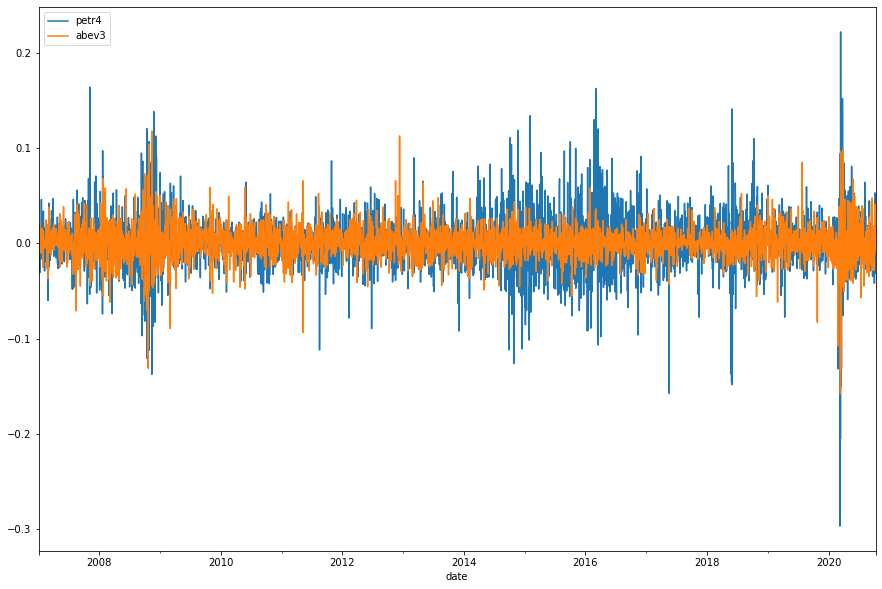

In [4]:
stock_rets.plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

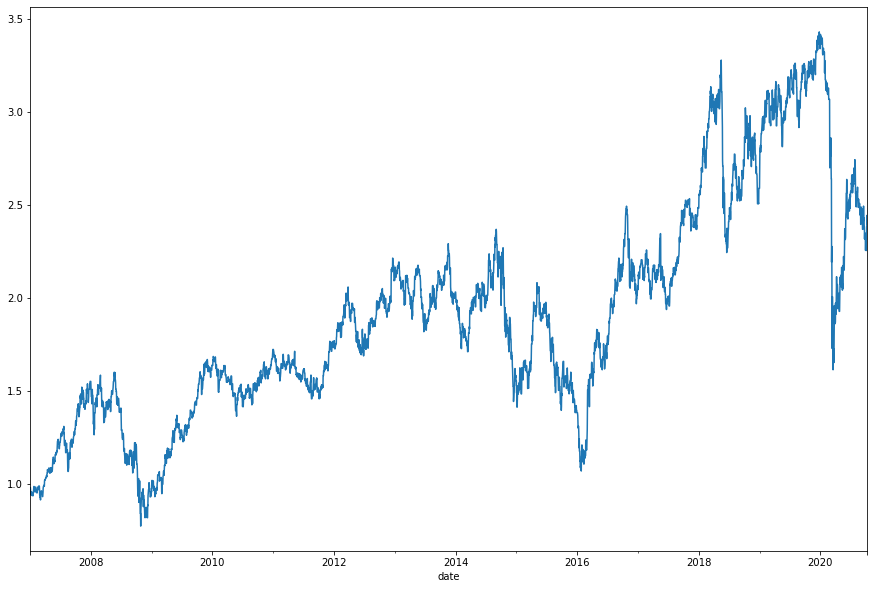

In [6]:
portfolio_returns = stock_rets.mean(axis=1)
(1+portfolio_returns).cumprod().plot(figsize=(15, 10))

### 2. Compute Ibovespa index excess returns

<AxesSubplot:xlabel='date'>

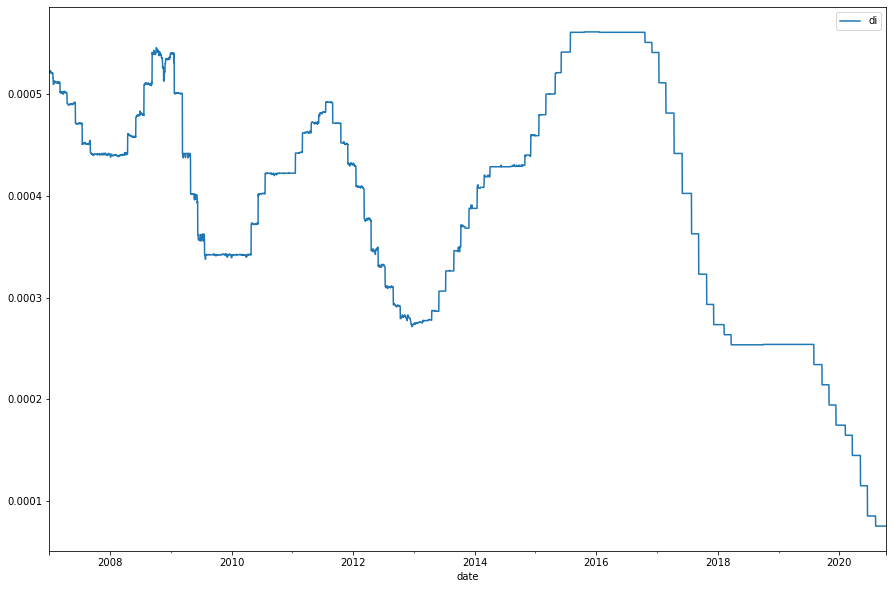

In [7]:
rates = stocks[["di"]].resample("D").mean().ffill() / (252 * 100)
rates.plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

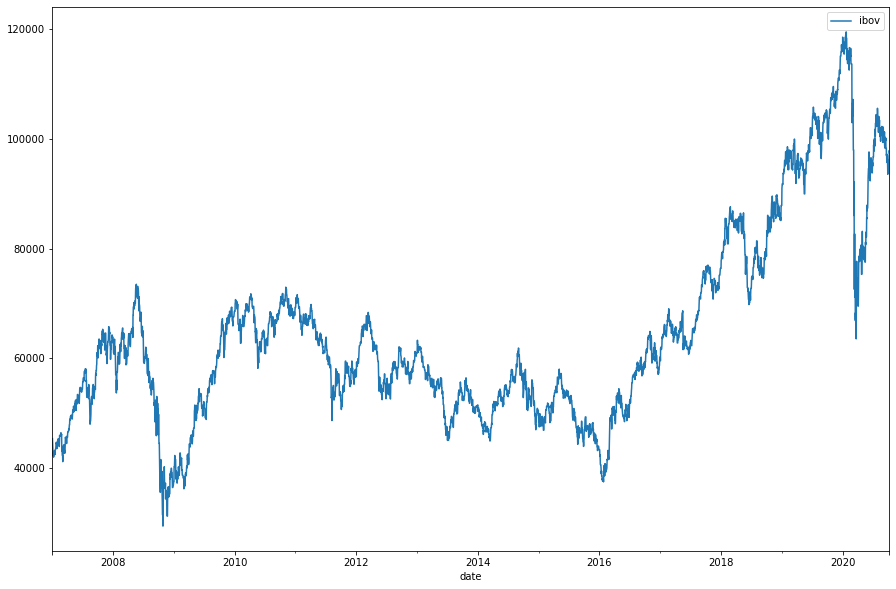

In [8]:
ibov = stocks[["ibov"]].resample("D").mean().ffill()
ibov.plot(figsize=(15, 10))

In [9]:
# ibov_ret = np.log(ibov.divide(ibov.shift(1), axis=0))
ibov_ret = ibov.pct_change()

<AxesSubplot:xlabel='date'>

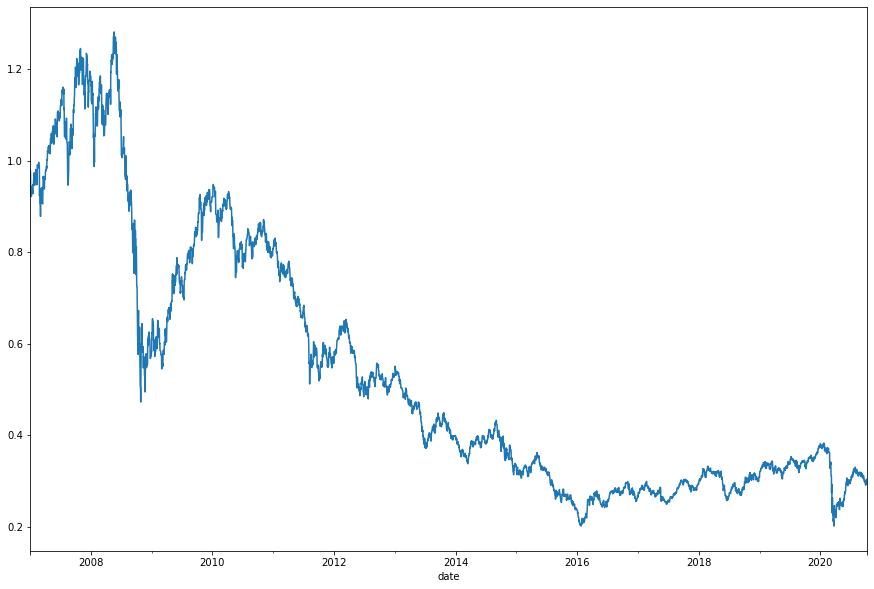

In [11]:
ibov_excess_ret = ibov_ret["ibov"] - rates["di"]
(1+ibov_excess_ret).cumprod().plot(figsize=(15, 10))

### 2. Estimate the CAPM model

<AxesSubplot:xlabel='date'>

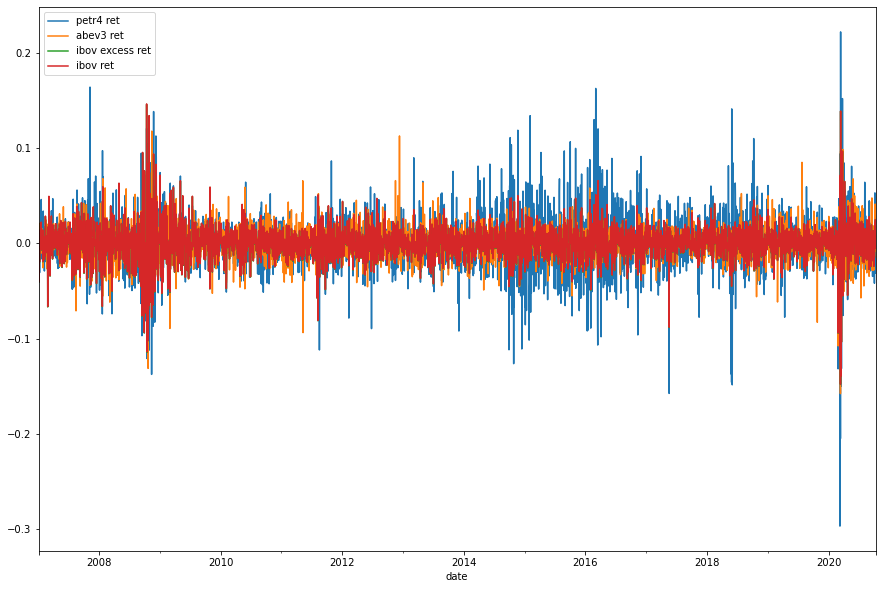

In [12]:
df = pd.concat([stock_rets, ibov_excess_ret, ibov_ret], axis=1).dropna()
df.columns = ["petr4 ret", "abev3 ret", "ibov excess ret", "ibov ret"]
df.plot(figsize=(15, 10))

In [13]:
df = sm.add_constant(df, prepend=False)
df.tail()

,petr4 ret,abev3 ret,ibov excess ret,ibov ret,const
date,,,,,
2020-10-05,0.053102,0.022346,0.021974,0.022049,1.0
2020-10-06,-0.004993,0.041374,-0.005008,-0.004933,1.0
2020-10-07,-0.007025,0.014243,-0.001006,-0.000931,1.0
2020-10-08,0.032845,0.011086,0.024986,0.025061,1.0
2020-10-09,-0.031311,-0.008041,-0.004538,-0.004463,1.0


In [14]:
mod = sm.OLS(df[["petr4 ret"]], df[["const", "ibov excess ret"]])
print(mod.fit().summary())

                            OLS Regression Results                            
Dep. Variable:              petr4 ret   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     6669.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:18:25   Log-Likelihood:                 13653.
No. Observations:                5029   AIC:                        -2.730e+04
Df Residuals:                    5027   BIC:                        -2.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000     

In [15]:
mod = sm.OLS(df[["abev3 ret"]], df[["const", "ibov excess ret"]])
print(mod.fit().summary())

                            OLS Regression Results                            
Dep. Variable:              abev3 ret   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     2120.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:18:30   Log-Likelihood:                 15066.
No. Observations:                5029   AIC:                        -3.013e+04
Df Residuals:                    5027   BIC:                        -3.011e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000     

In [16]:
mod = sm.OLS(df[["petr4 ret", "abev3 ret"]].mean(axis=1), df[["const", "ibov excess ret"]])
print(mod.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     9723.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:18:36   Log-Likelihood:                 16304.
No. Observations:                5029   AIC:                        -3.260e+04
Df Residuals:                    5027   BIC:                        -3.259e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000     